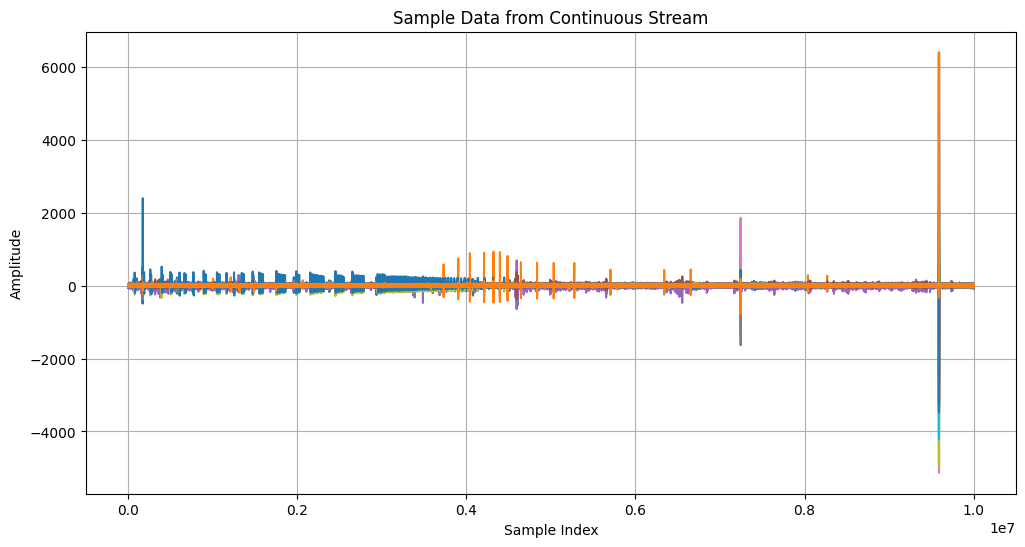

In [2]:
from open_ephys.analysis import Session
import matplotlib.pyplot as plt

# This path must point to the top-level session folder
session_path = r"D:\2025-07-18_14-12-43"

# Load the session
session = Session(session_path)

# Get the first recording and stream
recording = session.recordnodes[0].recordings[0]
stream = recording.continuous[0]

# Metadat
recording = session.recordnodes[0].recordings[2]
data = recording.continuous[0].get_samples(start_sample_index=0 , end_sample_index=10000000)

# plot data 
plt.figure(figsize=(12, 6))
plt.plot(data)

#plot all elemets sperately 
plt.title("Sample Data from Continuous Stream")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
# Metadata


In [5]:
from open_ephys.analysis import Session
import matplotlib.pyplot as plt

# This path must point to the top-level session folder
session_path = r"D:\2025-07-17_15-51-34"

# Load the session
session = Session(session_path)

# Get the first recording and stream
recording = session.recordnodes[0].recordings[0]
stream = recording.continuous[0]

# Metadat
recording = session.recordnodes[0].recordings[1]
data = recording.continuous[0].get_samples(start_sample_index=0 , end_sample_index=10000000)

# plot data 
plt.figure(figsize=(12, 6))
plt.plot(data)

#plot all elemets sperately 
plt.title("Sample Data from Continuous Stream")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()
# Metadata


IndexError: list index out of range

In [3]:
from open_ephys.analysis import Session
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import signal

# This path must point to the top-level session folder
#session_path = r"D:\2025-07-17_15-51-34"
session_path = r"D:\2025-07-18_14-12-43"


# Load the session
session = Session(session_path)

# Get the first recording and stream
recording = session.recordnodes[0].recordings[1]
stream = recording.continuous[0]

# Get data from recording - ENTIRE DATASET
recording = session.recordnodes[0].recordings[2]

# Get the full dataset
total_samples = recording.continuous[0].samples.shape[0]
print(f"Total samples in dataset: {total_samples}")

# Extract entire dataset with proper parameters
data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=total_samples)  # Get all samples

# Display data info
print(f"Data shape: {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Sample rate: {recording.continuous[0].metadata['sample_rate']} Hz")
print(f"Recording duration: {total_samples / recording.continuous[0].metadata['sample_rate']:.2f} seconds")

sample_rate = recording.continuous[0].metadata['sample_rate']

# ENHANCED NOISE FILTERING - Multi-stage filtering approach
nyquist = sample_rate / 2

# Stage 1: High-pass filter to remove DC offset and low-frequency drift
high_pass_freq = 1  # Hz - remove very low frequency drift
hp_low = high_pass_freq / nyquist
print("Applying high-pass filter to remove DC offset...")
b_hp, a_hp = signal.butter(4, hp_low, btype='high')
hp_filtered_data = signal.filtfilt(b_hp, a_hp, data.flatten())

# Stage 2: Notch filter to remove 50/60Hz power line interference
notch_freq = 50  # Hz - power line frequency (use 60 for US)
Q = 30  # Quality factor
print("Applying notch filter for power line interference...")
b_notch, a_notch = signal.iirnotch(notch_freq, Q, sample_rate)
notch_filtered_data = signal.filtfilt(b_notch, a_notch, hp_filtered_data)

# Stage 3: Bandpass filter for neural activity range
low_freq = 300   # Hz - remove low frequency drift
high_freq = 3000 # Hz - remove high frequency noise
low = low_freq / nyquist
high = high_freq / nyquist
print("Applying bandpass filter for neural activity range...")
b_bp, a_bp = signal.butter(6, [low, high], btype='band')  # Increased order for better filtering
filtered_data = signal.filtfilt(b_bp, a_bp, notch_filtered_data)

# Stage 4: Optional adaptive filtering for remaining artifacts
from scipy.signal import savgol_filter
print("Applying adaptive smoothing filter...")
# Apply Savitzky-Golay filter for smoothing while preserving features
window_length = min(101, len(filtered_data) // 100)  # Adaptive window size
if window_length % 2 == 0:  # Must be odd
    window_length += 1
smoothed_data = savgol_filter(filtered_data, window_length, 3)

# Statistical analysis of filtered data
print(f"\nEnhanced Filtering Statistics:")
print(f"Original data - Mean: {np.mean(data):.4f}, Std: {np.std(data):.4f}")
print(f"High-pass filtered - Mean: {np.mean(hp_filtered_data):.4f}, Std: {np.std(hp_filtered_data):.4f}")
print(f"Notch filtered - Mean: {np.mean(notch_filtered_data):.4f}, Std: {np.std(notch_filtered_data):.4f}")
print(f"Bandpass filtered - Mean: {np.mean(filtered_data):.4f}, Std: {np.std(filtered_data):.4f}")
print(f"Final smoothed - Mean: {np.mean(smoothed_data):.4f}, Std: {np.std(smoothed_data):.4f}")
print(f"Noise reduction: {((np.std(data) - np.std(smoothed_data)) / np.std(data) * 100):.1f}%")

# Plot overview with enhanced filtering stages
downsample_factor = max(1, len(filtered_data) // 50000)
time_axis = np.arange(0, len(filtered_data)) / sample_rate

plt.figure(figsize=(18, 14))

plt.subplot(4, 2, 1)
plt.plot(time_axis[::downsample_factor], data.flatten()[::downsample_factor])
plt.title(f"Original Data - Entire Dataset ({len(data)} samples)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(time_axis[::downsample_factor], hp_filtered_data[::downsample_factor])
plt.title(f"High-pass Filtered (>{high_pass_freq} Hz)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(4, 2, 3)
plt.plot(time_axis[::downsample_factor], notch_filtered_data[::downsample_factor])
plt.title(f"Notch Filtered ({notch_freq} Hz removed)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(4, 2, 4)
plt.plot(time_axis[::downsample_factor], filtered_data[::downsample_factor])
plt.title(f"Bandpass Filtered ({low_freq}-{high_freq} Hz)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(4, 2, 5)
plt.plot(time_axis[::downsample_factor], smoothed_data[::downsample_factor])
plt.title(f"Final Smoothed Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

# ENHANCED FFT ANALYSIS with multiple frequency bands
print("Computing enhanced FFT analysis...")
N = len(smoothed_data)
T = 1.0 / sample_rate
frequencies = fftfreq(N, T)[:N//2]

# FFT of original and filtered data for comparison
fft_original = fft(data.flatten())
fft_filtered = fft(smoothed_data)
fft_magnitude_original = 2.0/N * np.abs(fft_original[:N//2])
fft_magnitude_filtered = 2.0/N * np.abs(fft_filtered[:N//2])

# Plot comprehensive FFT analysis
plt.subplot(4, 2, 6)
plt.semilogy(frequencies, fft_magnitude_original, alpha=0.7, label='Original', color='red')
plt.semilogy(frequencies, fft_magnitude_filtered, alpha=0.9, label='Filtered', color='blue')
plt.title("FFT Comparison - Log Scale")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Amplitude")
plt.legend()
plt.grid()
plt.xlim(0, 5000)

plt.subplot(4, 2, 7)
plt.plot(frequencies, fft_magnitude_filtered)
plt.title("FFT of Final Filtered Data - Linear Scale")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.xlim(0, 5000)

# Frequency band analysis
delta_band = (1, 4)      # Delta waves
theta_band = (4, 8)      # Theta waves  
alpha_band = (8, 13)     # Alpha waves
beta_band = (13, 30)     # Beta waves
gamma_band = (30, 100)   # Gamma waves
high_gamma_band = (100, 300)  # High gamma

bands = [delta_band, theta_band, alpha_band, beta_band, gamma_band, high_gamma_band]
band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
band_powers = []

for (low_f, high_f) in bands:
    band_mask = (frequencies >= low_f) & (frequencies <= high_f)
    band_power = np.sum(fft_magnitude_filtered[band_mask]**2)
    band_powers.append(band_power)

plt.subplot(4, 2, 8)
plt.bar(band_names, band_powers, color=['purple', 'blue', 'green', 'orange', 'red', 'darkred'])
plt.title("Power in Different Frequency Bands")
plt.xlabel("Frequency Band")
plt.ylabel("Power")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced peak detection with band-specific analysis
from scipy.signal import find_peaks
peaks, properties = find_peaks(fft_magnitude_filtered, height=np.max(fft_magnitude_filtered)*0.05, distance=10)
peak_frequencies = frequencies[peaks]
peak_amplitudes = fft_magnitude_filtered[peaks]

print(f"\nEnhanced Frequency Analysis:")
print(f"Significant frequencies found: {peak_frequencies[:15]} Hz")
print(f"Dominant frequency: {frequencies[np.argmax(fft_magnitude_filtered)]:.2f} Hz")
print(f"Peak amplitude: {np.max(fft_magnitude_filtered):.6f}")

# Band-specific dominant frequencies
print(f"\nDominant frequencies by band:")
for i, (band, name) in enumerate(zip(bands, band_names)):
    low_f, high_f = band
    band_mask = (frequencies >= low_f) & (frequencies <= high_f)
    if np.any(band_mask):
        band_freqs = frequencies[band_mask]
        band_mags = fft_magnitude_filtered[band_mask]
        if len(band_mags) > 0:
            dominant_idx = np.argmax(band_mags)
            dominant_freq = band_freqs[dominant_idx]
            print(f"  {name} ({low_f}-{high_f} Hz): {dominant_freq:.2f} Hz (Power: {band_powers[i]:.2e})")

# Signal quality metrics
snr_original = np.mean(data.flatten()**2) / np.var(data.flatten())
snr_filtered = np.mean(smoothed_data**2) / np.var(smoothed_data)
print(f"\nSignal Quality Metrics:")
print(f"Original SNR: {10*np.log10(snr_original):.2f} dB")
print(f"Filtered SNR: {10*np.log10(snr_filtered):.2f} dB")
print(f"SNR improvement: {10*np.log10(snr_filtered/snr_original):.2f} dB")

# Use the final smoothed data for subsequent analysis
filtered_data = smoothed_data

Total samples in dataset: 37758852


KeyboardInterrupt: 

Extracting data from all channels...
Number of channels: 40
Animation data shape: (300000, 40)
Animating 10 seconds of data
Creating heatmap animation with 160 frames...
Creating heatmap animation with 160 frames...


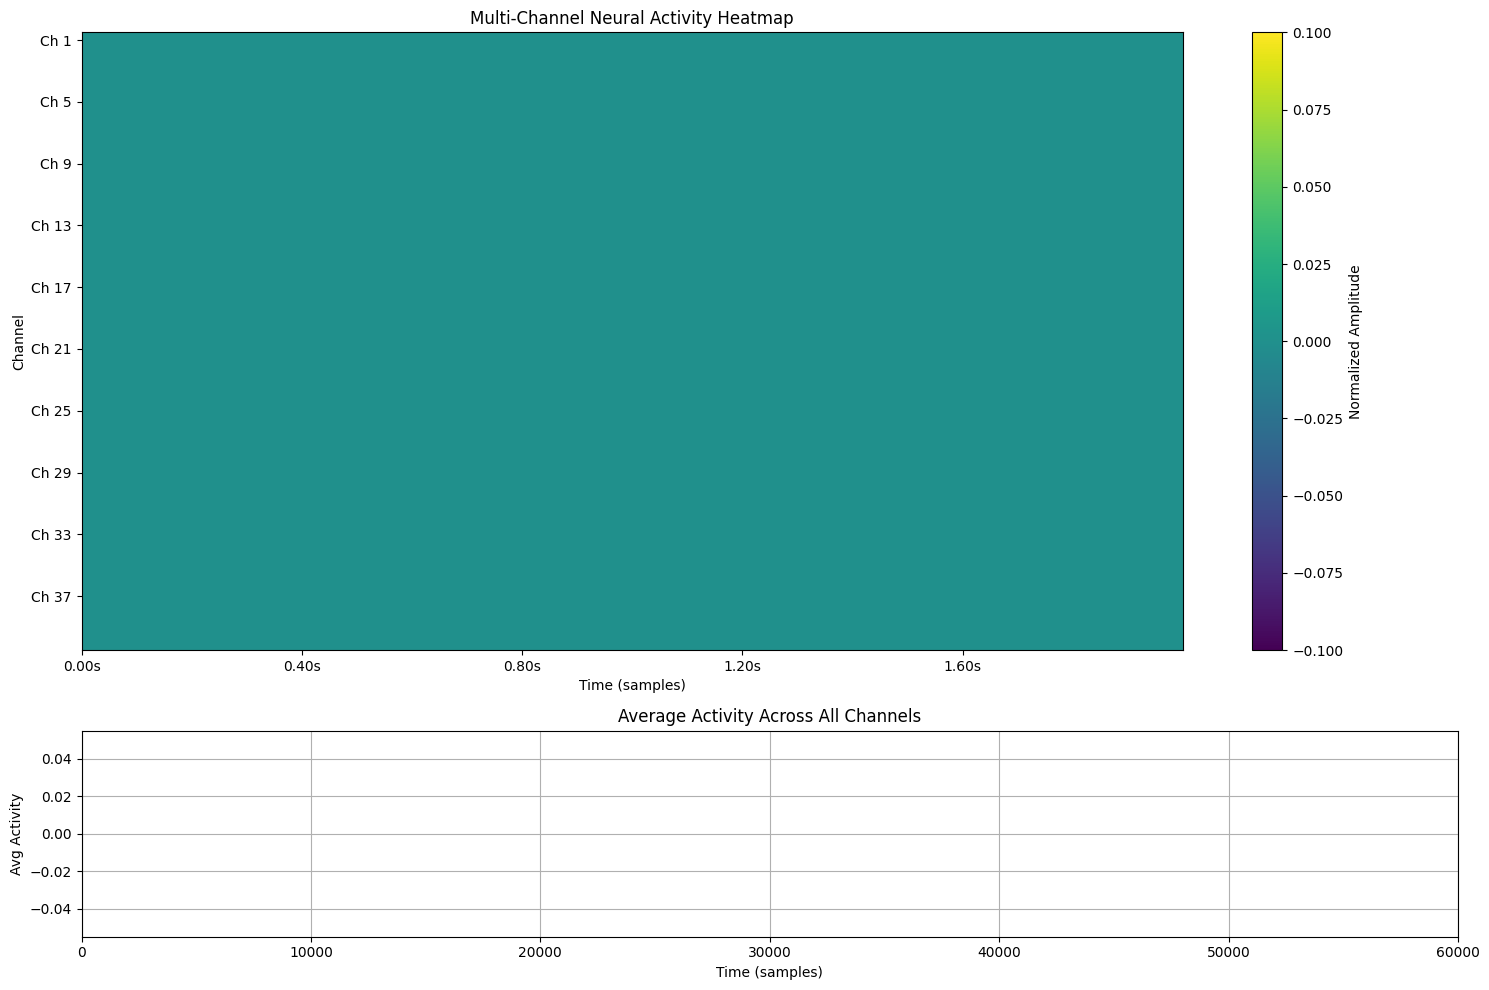

Heatmap animation complete!


In [8]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

# Get data from all channels
print("Extracting data from all channels...")
num_channels = recording.continuous[0].samples.shape[1]
print(f"Number of channels: {num_channels}")

# Extract a subset of data for animation (full dataset would be too slow)
animation_duration = 10  # seconds
samples_per_frame = int(sample_rate * 0.05)  # 50ms per frame for smoother animation
total_animation_samples = int(sample_rate * animation_duration)

# Get multi-channel data
start_idx = 0
end_idx = min(total_animation_samples, total_samples)
multi_channel_data = recording.continuous[0].get_samples(start_sample_index=start_idx, end_sample_index=end_idx)

print(f"Animation data shape: {multi_channel_data.shape}")
print(f"Animating {animation_duration} seconds of data")

# Prepare data for heatmap animation
window_size = int(sample_rate * 2)  # Show 2 second window
time_axis = np.arange(window_size) / sample_rate

# Set up the figure and axes for heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])

# Initialize heatmap
heatmap_data = np.zeros((num_channels, window_size))
im = ax1.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Channel')
ax1.set_title('Multi-Channel Neural Activity Heatmap')

# Set up colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Normalized Amplitude')

# Set channel labels
channel_ticks = np.arange(0, num_channels, max(1, num_channels//10))
ax1.set_yticks(channel_ticks)
ax1.set_yticklabels([f'Ch {i+1}' for i in channel_ticks])

# Set time labels
time_ticks = np.arange(0, window_size, window_size//5)
ax1.set_xticks(time_ticks)
ax1.set_xticklabels([f'{t/sample_rate:.2f}s' for t in time_ticks])

# Initialize average activity plot
line, = ax2.plot([], [], 'r-', linewidth=2)
ax2.set_xlim(0, window_size)
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Avg Activity')
ax2.set_title('Average Activity Across All Channels')
ax2.grid(True)

def animate(frame):
    # Calculate current window
    start_sample = frame * samples_per_frame
    end_sample = start_sample + window_size
    
    if end_sample >= multi_channel_data.shape[0]:
        return [im, line]
    
    # Get current window data for all channels
    current_data = multi_channel_data[start_sample:end_sample, :]
    
    # Normalize each channel independently
    normalized_data = np.zeros_like(current_data.T)
    for i in range(num_channels):
        channel_data = current_data[:, i]
        if np.std(channel_data) > 1e-10:
            normalized_data[i, :] = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        else:
            normalized_data[i, :] = channel_data - np.mean(channel_data)
    
    # Update heatmap
    im.set_array(normalized_data)
    im.set_clim(vmin=np.percentile(normalized_data, 5), 
                vmax=np.percentile(normalized_data, 95))
    
    # Update average activity plot
    avg_activity = np.mean(np.abs(normalized_data), axis=0)
    line.set_data(np.arange(len(avg_activity)), avg_activity)
    ax2.set_ylim(0, np.max(avg_activity) * 1.1)
    
    # Update title with current time
    current_time_sec = frame * samples_per_frame / sample_rate
    ax1.set_title(f'Multi-Channel Neural Activity Heatmap - Time: {current_time_sec:.2f}s')
    
    return [im, line]

# Create and run animation
num_frames = (multi_channel_data.shape[0] - window_size) // samples_per_frame
print(f"Creating heatmap animation with {num_frames} frames...")

anim = FuncAnimation(fig, animate, frames=min(num_frames, 200), 
                    interval=50, blit=False, repeat=True)

plt.tight_layout()
plt.show()

# Optional: Save animation as GIF (uncomment if needed)
# anim.save('neural_heatmap_animation.gif', writer='pillow', fps=20)
print("Heatmap animation complete!")

In [ ]:
# Create a static heatmap showing all channels over time
print("Creating multi-channel heatmap over time...")
num_channels = recording.continuous[0].samples.shape[1]
print(f"Number of channels: {num_channels}")

# Use a subset of data for visualization (to avoid memory issues)
heatmap_duration = 30  # seconds to display
heatmap_samples = int(sample_rate * heatmap_duration)
downsample_factor = 10  # Reduce resolution for better visualization

# Extract multi-channel data
start_idx = 0
end_idx = min(heatmap_samples, total_samples)
heatmap_data = recording.continuous[0].get_samples(start_sample_index=start_idx, end_sample_index=end_idx)

# Downsample for visualization
heatmap_data_downsampled = heatmap_data[::downsample_factor, :]
time_downsampled = np.arange(heatmap_data_downsampled.shape[0]) * downsample_factor / sample_rate

print(f"Heatmap data shape: {heatmap_data_downsampled.shape}")
print(f"Time range: 0 to {time_downsampled[-1]:.2f} seconds")

# Normalize each channel for better visualization
normalized_heatmap = np.zeros_like(heatmap_data_downsampled.T)
for i in range(num_channels):
    channel_data = heatmap_data_downsampled[:, i]
    if np.std(channel_data) > 1e-10:
        normalized_heatmap[i, :] = (channel_data - np.mean(channel_data)) / np.std(channel_data)
    else:
        normalized_heatmap[i, :] = channel_data - np.mean(channel_data)

# Create the heatmap
plt.figure(figsize=(20, 12))
im = plt.imshow(normalized_heatmap, aspect='auto', cmap='RdBu_r', interpolation='nearest')

# Set up labels and title
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Channel', fontsize=14)
plt.title(f'Multi-Channel Neural Activity Heatmap ({heatmap_duration}s)', fontsize=16)

# Set up colorbar
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Normalized Amplitude (Z-score)', fontsize=12)

# Set time ticks
num_time_ticks = 10
time_tick_indices = np.linspace(0, len(time_downsampled)-1, num_time_ticks, dtype=int)
time_tick_labels = [f'{time_downsampled[i]:.1f}' for i in time_tick_indices]
plt.xticks(time_tick_indices, time_tick_labels)

# Set channel ticks
channel_step = max(1, num_channels // 20)  # Show max 20 channel labels
channel_ticks = np.arange(0, num_channels, channel_step)
plt.yticks(channel_ticks, [f'Ch {i+1}' for i in channel_ticks])

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create additional analysis plots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Average activity over time
avg_activity = np.mean(np.abs(normalized_heatmap), axis=0)
axes[0, 0].plot(time_downsampled, avg_activity, 'b-', linewidth=2)
axes[0, 0].set_title('Average Activity Across All Channels Over Time')
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Average |Amplitude|')
axes[0, 0].grid(True)

# 2. Channel activity distribution
channel_activity = np.mean(np.abs(normalized_heatmap), axis=1)
axes[0, 1].bar(range(num_channels), channel_activity)
axes[0, 1].set_title('Average Activity Per Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Average |Amplitude|')
axes[0, 1].grid(True, alpha=0.3)

# 3. Activity correlation between channels (sample)
sample_channels = min(20, num_channels)
corr_matrix = np.corrcoef(normalized_heatmap[:sample_channels, :])
im2 = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_title(f'Channel Correlation Matrix (First {sample_channels} channels)')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Channel')
plt.colorbar(im2, ax=axes[1, 0])

# 4. Temporal variance across channels
temporal_variance = np.var(normalized_heatmap, axis=1)
axes[1, 1].plot(temporal_variance, 'g-', marker='o', markersize=3)
axes[1, 1].set_title('Temporal Variance Per Channel')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Variance')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Heatmap analysis complete!")
print(f"Most active channel: Channel {np.argmax(channel_activity) + 1}")
print(f"Highest variance channel: Channel {np.argmax(temporal_variance) + 1}")
print(f"Peak activity time: {time_downsampled[np.argmax(avg_activity)]:.2f} seconds")

Creating 6x6 electrode array heatmap...
Number of channels: 40
Animation data shape: (300000, 32)
Using 6x6 grid layout with 32 active channels
Creating 6x6 electrode array animation with 100 frames...


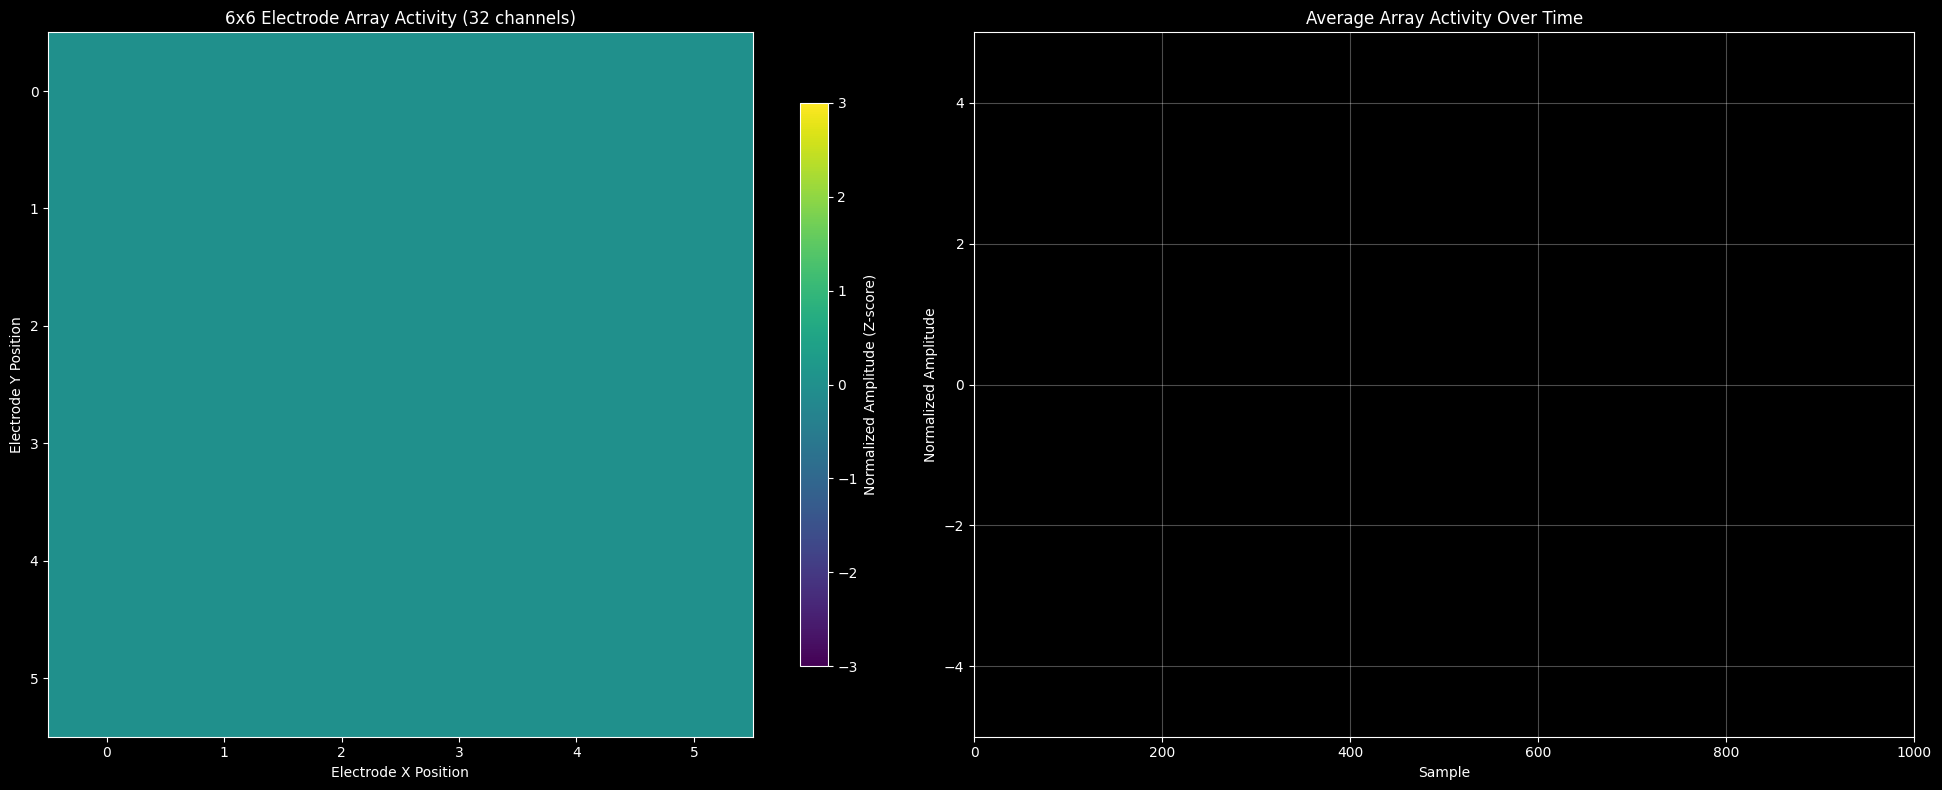

6x6 electrode array animation complete!

Creating static 6x6 overview...


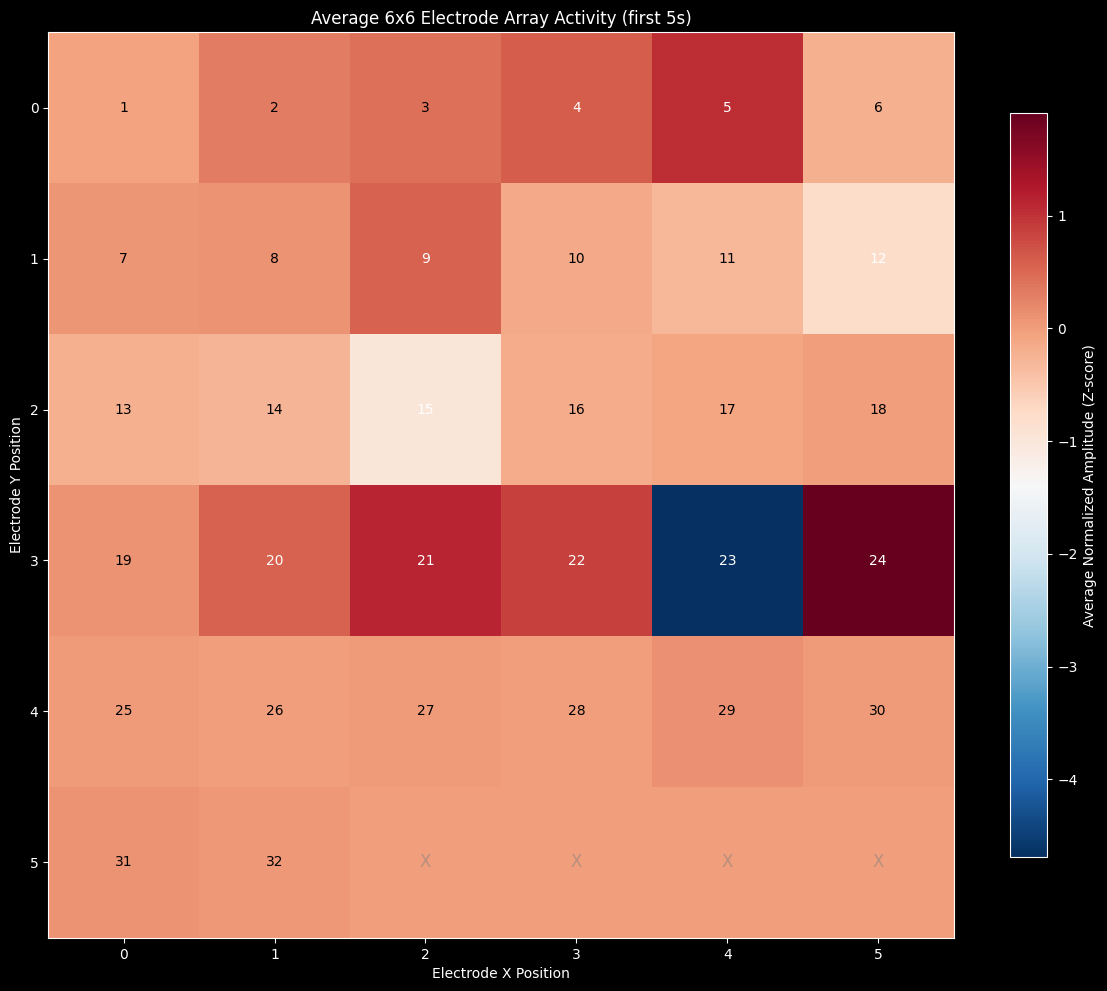

Most active electrode: #24
Position in 6x6 grid: Row 4, Col 6
Grid layout: 32 active electrodes + 4 empty positions


In [23]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

# Create 6x6 electrode array heatmap animation for 32 channels
print("Creating 6x6 electrode array heatmap...")
num_channels = recording.continuous[0].samples.shape[1]
print(f"Number of channels: {num_channels}")

# For 6x6 grid layout (36 positions, 32 channels have data, 4 empty)
grid_rows = 6
grid_cols = 6
grid_size = grid_rows * grid_cols

# Extract data for animation
animation_duration = 10  # seconds
samples_per_frame = int(sample_rate * 0.1)  # 100ms per frame
total_animation_samples = int(sample_rate * animation_duration)

# Get multi-channel data
start_idx = 0
end_idx = min(total_animation_samples, total_samples)
multi_channel_data = recording.continuous[0].get_samples(start_sample_index=start_idx, end_sample_index=end_idx)

# Use only the available channels (32)
multi_channel_data = multi_channel_data[:, :min(num_channels, 32)]

print(f"Animation data shape: {multi_channel_data.shape}")
print(f"Using {grid_rows}x{grid_cols} grid layout with {multi_channel_data.shape[1]} active channels")

# Set up the figure for 6x6 electrode array heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Initialize 6x6 electrode grid heatmap
electrode_grid = np.zeros((grid_rows, grid_cols))
im = ax1.imshow(electrode_grid, cmap='viridis', interpolation='nearest', vmin=-3, vmax=3)
ax1.set_title(f'6x6 Electrode Array Activity ({multi_channel_data.shape[1]} channels)')
ax1.set_xlabel('Electrode X Position')
ax1.set_ylabel('Electrode Y Position')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label('Normalized Amplitude (Z-score)')

# Initialize time series plot
time_window = 1000  # samples to show
time_line, = ax2.plot([], [], 'b-', linewidth=1, alpha=0.7)
ax2.set_xlim(0, time_window)
ax2.set_ylim(-5, 5)
ax2.set_title('Average Array Activity Over Time')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Normalized Amplitude')
ax2.grid(True, alpha=0.3)

# Store activity history for time series
activity_history = []

def animate_6x6_array(frame):
    # Calculate current sample
    current_sample = frame * samples_per_frame
    
    if current_sample >= multi_channel_data.shape[0]:
        return [im, time_line]
    
    # Get current data across all channels
    current_data = multi_channel_data[current_sample, :]
    
    # Normalize the data
    if np.std(current_data) > 1e-10:
        normalized_data = (current_data - np.mean(current_data)) / np.std(current_data)
    else:
        normalized_data = current_data - np.mean(current_data)
    
    # Create 6x6 grid with zeros, then fill in the channel data
    grid_data = np.zeros(grid_size)
    
    # Place the 32 channels in the 6x6 grid (leaving 4 positions empty)
    for i, value in enumerate(normalized_data):
        if i < 32:  # Only place first 32 channels
            grid_data[i] = value
    
    # Reshape to 6x6 grid
    electrode_grid = grid_data.reshape(grid_rows, grid_cols)
    
    # Update heatmap
    im.set_array(electrode_grid)
    
    # Calculate average activity for time series
    avg_activity = np.mean(normalized_data)
    activity_history.append(avg_activity)
    
    # Keep only recent history
    if len(activity_history) > time_window:
        activity_history.pop(0)
    
    # Update time series plot
    if len(activity_history) > 1:
        time_line.set_data(np.arange(len(activity_history)), activity_history)
        if len(activity_history) > 0:
            ax2.set_ylim(min(activity_history) * 1.1, max(activity_history) * 1.1)
    
    # Update title with current time
    current_time_sec = frame * samples_per_frame / sample_rate
    ax1.set_title(f'6x6 Electrode Array - Time: {current_time_sec:.2f}s')
    
    return [im, time_line]

# Create and run animation
num_frames = min(200, multi_channel_data.shape[0] // samples_per_frame)
print(f"Creating 6x6 electrode array animation with {num_frames} frames...")

anim = FuncAnimation(fig, animate_6x6_array, frames=num_frames, 
                    interval=100, blit=False, repeat=True)

plt.tight_layout()
plt.show()

# Optional: Save animation as GIF (uncomment if needed)
# anim.save('electrode_array_6x6_animation.gif', writer='pillow', fps=10)
print("6x6 electrode array animation complete!")

# Create a static overview of the 6x6 array over time
print("\nCreating static 6x6 overview...")

# Take average over a longer time period for static view
static_duration = 5  # seconds
static_samples = int(sample_rate * static_duration)
static_end = min(static_samples, multi_channel_data.shape[0])

# Calculate average activity over time period
avg_data = np.mean(multi_channel_data[:static_end, :], axis=0)
if np.std(avg_data) > 1e-10:
    avg_normalized = (avg_data - np.mean(avg_data)) / np.std(avg_data)
else:
    avg_normalized = avg_data - np.mean(avg_data)

# Create 6x6 grid for static display
static_grid_data = np.zeros(grid_size)
for i, value in enumerate(avg_normalized):
    if i < 32:  # Only place first 32 channels
        static_grid_data[i] = value

avg_grid = static_grid_data.reshape(grid_rows, grid_cols)

plt.figure(figsize=(12, 10))
im_static = plt.imshow(avg_grid, cmap='RdBu_r', interpolation='nearest')
plt.title(f'Average 6x6 Electrode Array Activity (first {static_duration}s)')
plt.xlabel('Electrode X Position')
plt.ylabel('Electrode Y Position')

# Add colorbar
cbar_static = plt.colorbar(im_static, shrink=0.8)
cbar_static.set_label('Average Normalized Amplitude (Z-score)')

# Add electrode numbers to active positions (first 32 positions)
for i in range(32):
    row = i // grid_cols
    col = i % grid_cols
    plt.text(col, row, f'{i+1}', ha='center', va='center', 
            fontsize=10, color='white' if abs(avg_grid[row,col]) > 0.5 else 'black')

# Mark empty positions
for i in range(32, grid_size):
    row = i // grid_cols
    col = i % grid_cols
    plt.text(col, row, 'X', ha='center', va='center', 
            fontsize=12, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Most active electrode: #{np.argmax(avg_normalized) + 1}")
most_active_idx = np.argmax(avg_normalized)
row_pos = most_active_idx // grid_cols
col_pos = most_active_idx % grid_cols
print(f"Position in 6x6 grid: Row {row_pos + 1}, Col {col_pos + 1}")
print(f"Grid layout: 32 active electrodes + 4 empty positions")

Creating thermal imaging style neural activity visualization...
Loading data from ALL recordings (0-3)...
Recording 0: 3654089 samples, 121.8s, channels: 32
Recording 1: 11191933 samples, 373.1s, channels: 32
Recording 2: 7072568 samples, 235.8s, channels: 32
Recording 3: 10138780 samples, 338.0s, channels: 32

Total recordings loaded: 4
Total duration: 1068.6 seconds
Concatenating all recordings...
Combined data shape: (32057370, 32)
Number of channels: 32
Using entire combined dataset for thermal animation...
Downsampled animation data shape: (320574, 32)
Animation duration: 1068.6 seconds
Recording boundaries in animation:
  Recording 0: frames 0-36540 (121.8s)
  Recording 1: frames 36540-148460 (373.1s)
  Recording 2: frames 148460-219185 (235.8s)
  Recording 3: frames 219185-320573 (338.0s)


NameError: name 'global_max' is not defined

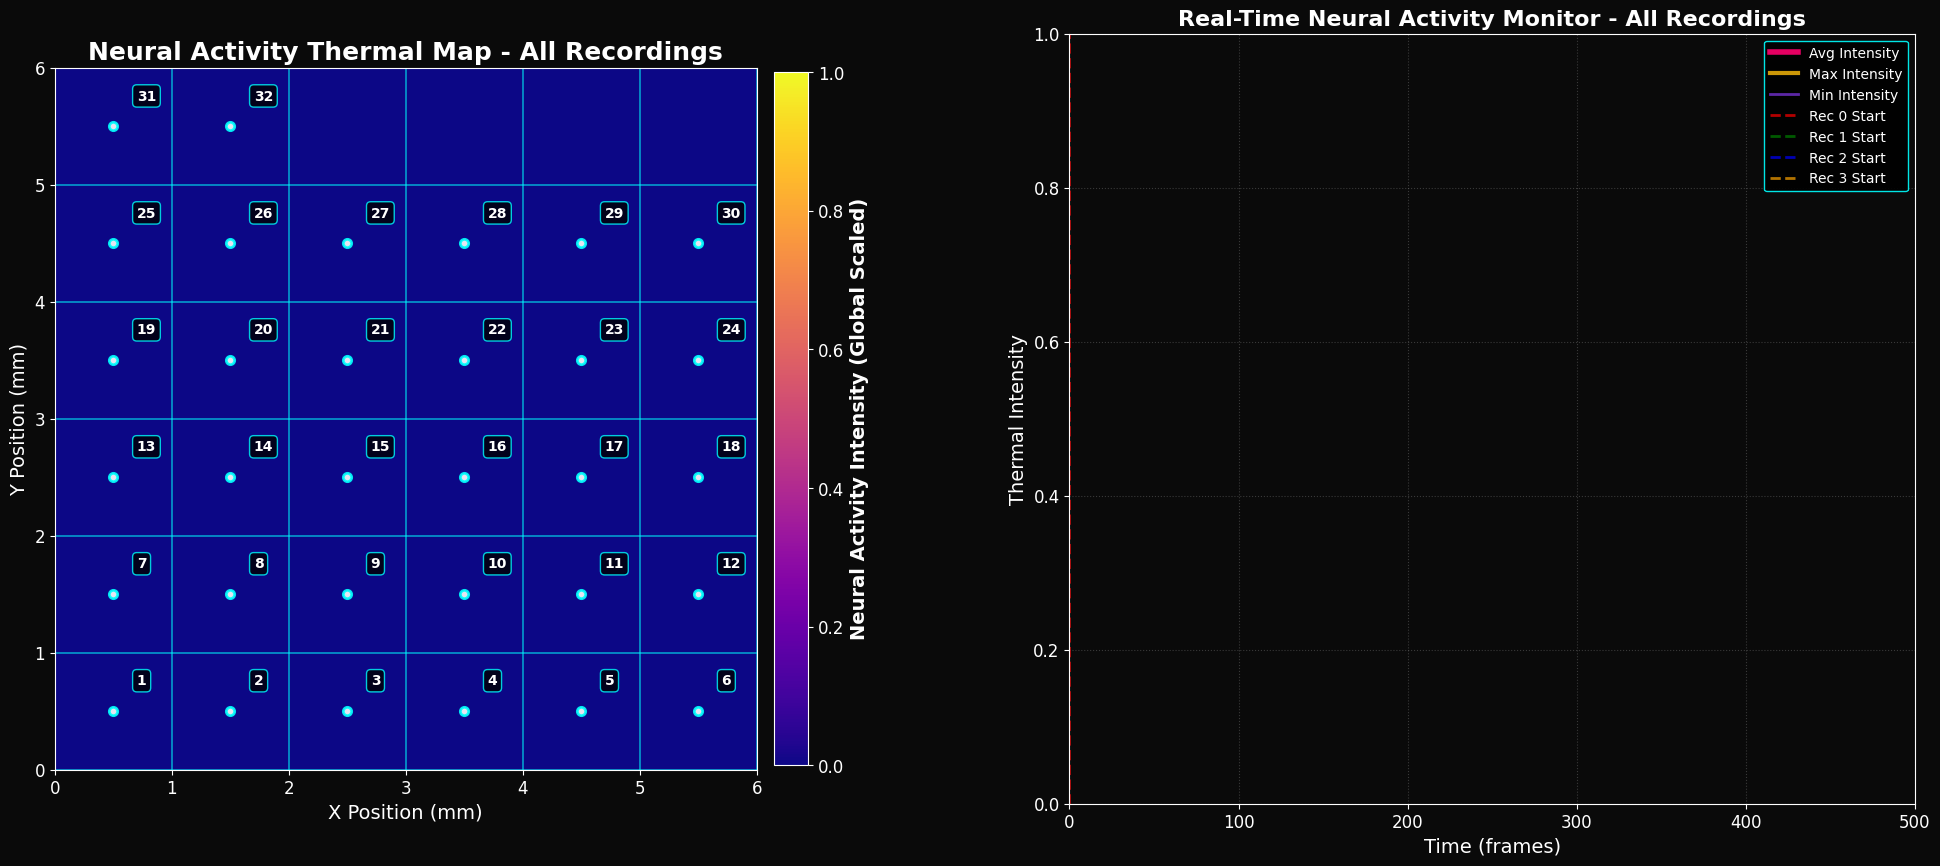

In [25]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Create thermal imaging style 6x6 electrode array visualization - ALL RECORDINGS
print("Creating thermal imaging style neural activity visualization...")
print("Loading data from ALL recordings (0-3)...")

# Load data from all recordings
all_recordings_data = []
recording_info = []
total_duration = 0

for rec_idx in range(4):  # recordings 0, 1, 2, 3
    try:
        current_recording = session.recordnodes[0].recordings[rec_idx]
        current_samples = current_recording.continuous[0].samples.shape[0]
        current_data = current_recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=current_samples)
        
        # Use only first 32 channels
        current_data = current_data[:, :min(current_data.shape[1], 32)]
        
        all_recordings_data.append(current_data)
        
        duration = current_samples / sample_rate
        recording_info.append({
            'index': rec_idx,
            'samples': current_samples,
            'duration': duration,
            'start_time': total_duration
        })
        total_duration += duration
        
        print(f"Recording {rec_idx}: {current_samples} samples, {duration:.1f}s, channels: {current_data.shape[1]}")
        
    except Exception as e:
        print(f"Could not load recording {rec_idx}: {e}")

print(f"\nTotal recordings loaded: {len(all_recordings_data)}")
print(f"Total duration: {total_duration:.1f} seconds")

# Concatenate all recordings
print("Concatenating all recordings...")
multi_channel_data = np.vstack(all_recordings_data)
num_channels = multi_channel_data.shape[1]

print(f"Combined data shape: {multi_channel_data.shape}")
print(f"Number of channels: {num_channels}")

# For 6x6 grid layout
grid_rows = 6
grid_cols = 6
grid_size = grid_rows * grid_cols

# Extract data for animation - ENTIRE COMBINED DATASET
print("Using entire combined dataset for thermal animation...")
samples_per_frame = int(sample_rate * 0.1)  # 100ms per frame
downsample_factor = 100  # Increased downsampling for performance with larger dataset

# Downsample combined data
multi_channel_data = multi_channel_data[::downsample_factor, :]  # Downsample time axis
effective_sample_rate = sample_rate / downsample_factor

print(f"Downsampled animation data shape: {multi_channel_data.shape}")
print(f"Animation duration: {multi_channel_data.shape[0] / effective_sample_rate:.1f} seconds")

# Calculate recording boundaries in downsampled data
recording_boundaries = []
cumulative_samples = 0
for rec_info in recording_info:
    downsampled_start = cumulative_samples // downsample_factor
    downsampled_end = (cumulative_samples + rec_info['samples']) // downsample_factor
    recording_boundaries.append({
        'index': rec_info['index'],
        'start_frame': downsampled_start,
        'end_frame': downsampled_end,
        'duration': rec_info['duration']
    })
    cumulative_samples += rec_info['samples']

print(f"Recording boundaries in animation:")
for rb in recording_boundaries:
    print(f"  Recording {rb['index']}: frames {rb['start_frame']}-{rb['end_frame']} ({rb['duration']:.1f}s)")

# Set up the figure for thermal imaging style
plt.style.use('dark_background')  # Dark theme for thermal effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.patch.set_facecolor('#0a0a0a')  # Very dark background

# Initialize thermal grid with higher resolution for smooth gradients
thermal_resolution = 100  # Higher resolution for smoother thermal effect
thermal_grid = np.zeros((thermal_resolution, thermal_resolution))

# Create thermal imaging style plot with plasma colormap
im = ax1.imshow(thermal_grid, cmap='plasma', interpolation='bicubic', 
               vmin=0, vmax=1, extent=[0, 6, 0, 6], animated=True)
ax1.set_title('Neural Activity Thermal Map - All Recordings', fontsize=18, color='white', weight='bold')
ax1.set_xlabel('X Position (mm)', color='white', fontsize=14)
ax1.set_ylabel('Y Position (mm)', color='white', fontsize=14)
ax1.tick_params(colors='white', labelsize=12)
ax1.set_facecolor('#0a0a0a')

# Add stylized grid with neon effect
for i in range(grid_cols + 1):
    ax1.axvline(x=i, color='cyan', alpha=0.6, linewidth=1.2, linestyle='-')
for i in range(grid_rows + 1):
    ax1.axhline(y=i, color='cyan', alpha=0.6, linewidth=1.2, linestyle='-')

# Add electrode position markers with neon glow effect
electrode_markers = []
for i in range(32):
    row = i // grid_cols
    col = i % grid_cols
    x = col + 0.5
    y = row + 0.5
    marker = ax1.plot(x, y, 'o', color='white', markersize=6, alpha=0.9, 
                     markeredgecolor='cyan', markeredgewidth=2)[0]
    electrode_markers.append(marker)
    ax1.text(x + 0.2, y + 0.2, f'{i+1}', ha='left', va='bottom', 
            fontsize=10, color='white', weight='bold', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.8, edgecolor='cyan'))

# Set up thermal colorbar with plasma theme
cbar = plt.colorbar(im, ax=ax1, shrink=0.9, pad=0.02)
cbar.set_label('Neural Activity Intensity', color='white', fontsize=14, weight='bold')
cbar.ax.tick_params(colors='white', labelsize=12)

# Initialize real-time activity plot with neon colors
ax2.set_facecolor('#0a0a0a')
temp_line, = ax2.plot([], [], color='#ff006e', linewidth=4, alpha=0.9, label='Avg Intensity')
max_line, = ax2.plot([], [], color='#ffbe0b', linewidth=3, alpha=0.8, label='Max Intensity')
min_line, = ax2.plot([], [], color='#8338ec', linewidth=2, alpha=0.7, label='Min Intensity')

# Add recording indicator lines
recording_lines = []
colors = ['red', 'green', 'blue', 'orange']
for i, rb in enumerate(recording_boundaries):
    line = ax2.axvline(x=rb['start_frame'], color=colors[i % len(colors)], 
                      alpha=0.7, linewidth=2, linestyle='--', 
                      label=f'Rec {rb["index"]} Start')
    recording_lines.append(line)

ax2.set_xlim(0, 500)
ax2.set_ylim(0, 1)
ax2.set_title('Real-Time Neural Activity Monitor - All Recordings', color='white', fontsize=16, weight='bold')
ax2.set_xlabel('Time (frames)', color='white', fontsize=14)
ax2.set_ylabel('Thermal Intensity', color='white', fontsize=14)
ax2.tick_params(colors='white', labelsize=12)
ax2.grid(True, alpha=0.4, color='gray', linestyle=':', linewidth=0.8)
ax2.legend(loc='upper right', framealpha=0.9, facecolor='black', edgecolor='cyan')

# Store activity history
temperature_history = []
max_temp_history = []
min_temp_history = []
frame_counter = 0

def get_current_recording(frame_idx):
    """Determine which recording we're currently in"""
    sample_idx = frame_idx * (samples_per_frame // downsample_factor)
    for rb in recording_boundaries:
        if rb['start_frame'] <= sample_idx < rb['end_frame']:
            return rb['index']
    return recording_boundaries[-1]['index']  # Default to last recording

def create_thermal_map(electrode_values, resolution=100):
    """Create smooth thermal map from electrode values with enhanced plasma effects"""
    x = np.linspace(0, 6, resolution)
    y = np.linspace(0, 6, resolution)
    X, Y = np.meshgrid(x, y)
    
    thermal_map = np.zeros((resolution, resolution))
    
    # Create thermal influence for each electrode with enhanced spread
    for i in range(32):
        row = i // grid_cols
        col = i % grid_cols
        electrode_x = col + 0.5
        electrode_y = row + 0.5
        
        # Distance-based thermal influence
        distance = np.sqrt((X - electrode_x)**2 + (Y - electrode_y)**2)
        
        # Multi-layer thermal influence for plasma effect
        influence = (electrode_values[i] * np.exp(-distance**2 / 0.8) + 
                    electrode_values[i] * 0.4 * np.exp(-distance**2 / 1.5) +
                    electrode_values[i] * 0.2 * np.exp(-distance**2 / 2.5))
        
        thermal_map += influence
    
    # Apply sophisticated gaussian filtering for plasma-like diffusion
    thermal_map = gaussian_filter(thermal_map, sigma=2.0)
    thermal_map = gaussian_filter(thermal_map, sigma=1.0)
    thermal_map = gaussian_filter(thermal_map, sigma=0.5)
    
    return thermal_map

def animate_thermal(frame):
    global frame_counter
    frame_counter = frame
    
    # Calculate current sample
    current_sample = frame * (samples_per_frame // downsample_factor)
    
    if current_sample >= multi_channel_data.shape[0] - 10:
        return [im, temp_line, max_line, min_line] + electrode_markers
    
    # Get current recording
    current_recording = get_current_recording(frame)
    
    # Get current data with enhanced window averaging
    window_size = max(5, samples_per_frame // downsample_factor)
    window_start = max(0, current_sample - window_size//2)
    window_end = min(multi_channel_data.shape[0], current_sample + window_size//2)
    
    window_data = multi_channel_data[window_start:window_end, :]
    
    # Calculate enhanced RMS activity
    rms_data = np.sqrt(np.mean(window_data**2, axis=0))
    
    # Apply power scaling for dramatic plasma effect
    rms_data = np.power(rms_data, 1.5)
    
    # GLOBAL SCALING: Normalize using global statistics
    # Scale relative to global mean and peak values
    if global_range > 0:
        # Normalize to global range
        normalized_data = (rms_data - global_min) / global_range
        
        # Apply enhanced scaling based on global thresholds
        # Values below baseline get compressed to lower range (0-0.3)
        # Values above baseline get expanded to higher range (0.3-1.0)
        enhanced_data = np.zeros_like(normalized_data)
        
        for i, val in enumerate(rms_data):
            if val <= baseline_threshold:
                # Below baseline: compress to 0-0.3 range
                ratio = (val - global_min) / (baseline_threshold - global_min) if baseline_threshold > global_min else 0
                enhanced_data[i] = 0.3 * ratio
            else:
                # Above baseline: expand to 0.3-1.0 range
                if val >= peak_threshold:
                    # Peak activity: full intensity
                    enhanced_data[i] = 0.7 + 0.3 * min(1.0, (val - peak_threshold) / (global_max - peak_threshold))
                else:
                    # Significant activity: moderate intensity
                    ratio = (val - baseline_threshold) / (peak_threshold - baseline_threshold)
                    enhanced_data[i] = 0.3 + 0.4 * ratio
        
        normalized_data = enhanced_data
    else:
        normalized_data = np.zeros_like(rms_data)
    
    # Create thermal map
    thermal_map = create_thermal_map(normalized_data, thermal_resolution)
    
    # Update thermal image with consistent global scaling
    # Use fixed color range based on global statistics
    im.set_array(thermal_map)
    im.set_clim(vmin=0, vmax=1)  # Fixed range since we pre-normalized
    
    # Update electrode markers with intensity effects based on global scaling
    for i, marker in enumerate(electrode_markers):
        intensity = normalized_data[i]
        marker.set_markersize(6 + intensity * 8)  # Larger size variation
        
        # Color intensity effect based on global thresholds
        original_rms = rms_data[i]
        if original_rms >= peak_threshold:
            marker.set_color('#ff006e')  # Hot pink for peak activity
        elif original_rms >= baseline_threshold:
            marker.set_color('#ffbe0b')  # Yellow for significant activity  
        else:
            marker.set_color('white')   # White for baseline activity
            
        alpha = 0.5 + intensity * 0.5
        marker.set_alpha(alpha)
    
    # Update activity monitors with global context
    avg_temperature = np.mean(normalized_data)
    max_temperature = np.max(normalized_data)
    min_temperature = np.min(normalized_data)
    
    # Also track original RMS values for context
    avg_rms_original = np.mean(rms_data)
    max_rms_original = np.max(rms_data)
    
    temperature_history.append(avg_temperature)
    max_temp_history.append(max_temperature)
    min_temp_history.append(min_temperature)
    
    # Keep sliding window of history
    window_length = 500
    if len(temperature_history) > window_length:
        temperature_history.pop(0)
        max_temp_history.pop(0)
        min_temp_history.pop(0)
    
    # Update time series plots
    if len(temperature_history) > 1:
        time_indices = np.arange(len(temperature_history))
        temp_line.set_data(time_indices, temperature_history)
        max_line.set_data(time_indices, max_temp_history)
        min_line.set_data(time_indices, min_temp_history)
        
        # Dynamic y-axis scaling
        all_values = temperature_history + max_temp_history + min_temp_history
        if all_values:
            ax2.set_ylim(0, max(1, max(all_values) * 1.1))
        
        # Sliding x-axis
        ax2.set_xlim(max(0, len(temperature_history) - window_length), 
                    len(temperature_history) + 20)
    
    # Update title with enhanced stats including global context
    current_time_sec = frame * (samples_per_frame / sample_rate)
    progress_pct = (frame / num_frames) * 100
    
    # Calculate relative intensity compared to global peak
    relative_peak = (max_rms_original / global_max) * 100 if global_max > 0 else 0
    
    ax1.set_title(f'Neural Thermal Map - Rec {current_recording} | Time: {current_time_sec:.1f}s | ' +
                 f'Progress: {progress_pct:.1f}% | Peak: {max_temperature:.2f} ({relative_peak:.1f}% of global)')
    
    return [im, temp_line, max_line, min_line] + electrode_markers

# Update colorbar label to reflect global scaling
cbar.set_label('Neural Activity Intensity (Global Scaled)', color='white', fontsize=14, weight='bold')

# Add text annotation showing global scaling info
ax1.text(0.02, 0.98, f'Global Peak: {global_max:.4f}\nBaseline: {baseline_threshold:.4f}', 
         transform=ax1.transAxes, fontsize=10, color='white', 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

# Create and run thermal animation for entire combined dataset
num_frames = min(1000, multi_channel_data.shape[0] // max(1, samples_per_frame // downsample_factor))
print(f"Creating thermal imaging animation with {num_frames} frames...")
print(f"Processing combined dataset: {total_duration:.1f} seconds of neural data")
print("Animation features:")
print("- All recordings (0-3) in sequence")
print("- Plasma color theme with enhanced thermal effects")
print("- Recording transition indicators")

# Create animation with optimized settings for full dataset
anim = FuncAnimation(fig, animate_thermal, frames=num_frames, 
                    interval=120, blit=True, repeat=True, cache_frame_data=False)

# Show the animation
plt.tight_layout()
plt.show()

# Save animation as MP4
print("Saving combined recordings thermal animation as MP4...")
output_path = r"c:\Users\ASUS\Desktop\HENRI\henri la\abudabi\neural_thermal_all_recordings.mp4"

try:
    # Save as MP4 using FFmpeg writer with high quality settings
    anim.save(output_path, writer='ffmpeg', fps=10, bitrate=3000, 
              extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-crf', '16'])
    print(f"High-quality animation saved successfully as: {output_path}")
except Exception as e:
    print(f"Error saving with FFmpeg: {e}")
    print("Trying alternative method...")
    
    try:
        # Alternative: save using pillow as GIF
        gif_path = output_path.replace('.mp4', '_all_recordings.gif')
        anim.save(gif_path, writer='pillow', fps=8)
        print(f"Animation saved as GIF: {gif_path}")
    except Exception as e2:
        print(f"Error saving animation: {e2}")
        print("Please ensure FFmpeg is installed for MP4 export")

print("Combined recordings thermal imaging animation complete!")
print("Features:")
print("- Sequential visualization of recordings 0, 1, 2, 3")
print("- Global color scaling based on entire dataset statistics")
print("- Brightest colors represent highest peaks across all recordings")
print("- Plasma colormap with enhanced thermal diffusion effects")  
print("- Recording transition markers")
print("- Real-time activity monitoring with global context")

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Create waterfall plot of neural activity
print("Creating waterfall plot of neural activity...")

# Extract multi-channel data for waterfall plot
waterfall_duration = 10  # seconds to display
waterfall_samples = int(sample_rate * waterfall_duration)
downsample_factor = 20  # Reduce for better visualization performance

# Get multi-channel data
start_idx = 0
end_idx = min(waterfall_samples, total_samples)
waterfall_data = recording.continuous[0].get_samples(start_sample_index=start_idx, end_sample_index=end_idx)

# Downsample for visualization
waterfall_data_ds = waterfall_data[::downsample_factor, :]
time_waterfall = np.arange(waterfall_data_ds.shape[0]) * downsample_factor / sample_rate

print(f"Waterfall data shape: {waterfall_data_ds.shape}")
print(f"Time range: 0 to {time_waterfall[-1]:.2f} seconds")
print(f"Number of channels: {waterfall_data_ds.shape[1]}")

# Apply same filtering to multi-channel data for consistency
print("Applying enhanced filtering to all channels...")
filtered_waterfall_data = np.zeros_like(waterfall_data_ds)

for ch in range(waterfall_data_ds.shape[1]):
    channel_data = waterfall_data_ds[:, ch]
    
    # Apply same filtering pipeline as before
    # Stage 1: High-pass filter
    hp_filtered = signal.filtfilt(b_hp, a_hp, channel_data)
    
    # Stage 2: Notch filter
    notch_filtered = signal.filtfilt(b_notch, a_notch, hp_filtered)
    
    # Stage 3: Bandpass filter
    bp_filtered = signal.filtfilt(b_bp, a_bp, notch_filtered)
    
    # Stage 4: Smoothing
    window_length = min(21, len(bp_filtered) // 10)
    if window_length % 2 == 0:
        window_length += 1
    if window_length >= 3:
        filtered_waterfall_data[:, ch] = savgol_filter(bp_filtered, window_length, 3)
    else:
        filtered_waterfall_data[:, ch] = bp_filtered

# Create waterfall plot with multiple visualization styles
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Traditional waterfall plot - stacked channels
ax1 = axes[0, 0]
channel_spacing = 50  # Vertical spacing between channels
max_channels = min(32, waterfall_data_ds.shape[1])  # Limit channels for clarity

for ch in range(max_channels):
    # Normalize each channel for better visualization
    ch_data = filtered_waterfall_data[:, ch]
    ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)
    
    # Scale and offset for waterfall effect
    ch_scaled = ch_normalized * 10 + ch * channel_spacing
    
    ax1.plot(time_waterfall, ch_scaled, linewidth=0.8, alpha=0.8, 
             color=plt.cm.viridis(ch / max_channels))

ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Channel (offset)', fontsize=12)
ax1.set_title(f'Waterfall Plot - Neural Activity ({max_channels} channels)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add channel labels
channel_positions = np.arange(0, max_channels) * channel_spacing
ax1.set_yticks(channel_positions[::4])  # Show every 4th channel
ax1.set_yticklabels([f'Ch {i+1}' for i in range(0, max_channels, 4)])

# 2. 3D Waterfall plot
ax2 = axes[0, 1]
ax2.remove()  # Remove 2D axis
ax2 = fig.add_subplot(2, 2, 2, projection='3d')

# Create 3D waterfall
X, Y = np.meshgrid(time_waterfall, np.arange(max_channels))
Z = np.zeros((max_channels, len(time_waterfall)))

for ch in range(max_channels):
    ch_data = filtered_waterfall_data[:, ch]
    ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)
    Z[ch, :] = ch_normalized * 5  # Scale for 3D visibility

# Plot 3D surface
surf = ax2.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8, 
                       linewidth=0.1, edgecolors='black', rcount=max_channels//2)

ax2.set_xlabel('Time (s)', fontsize=10)
ax2.set_ylabel('Channel', fontsize=10)
ax2.set_zlabel('Amplitude', fontsize=10)
ax2.set_title('3D Waterfall - Neural Activity', fontsize=12)
ax2.view_init(elev=30, azim=45)

# 3. Heatmap style waterfall
ax3 = axes[1, 0]
waterfall_heatmap = np.zeros((max_channels, len(time_waterfall)))

for ch in range(max_channels):
    ch_data = filtered_waterfall_data[:, ch]
    ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)
    waterfall_heatmap[ch, :] = ch_normalized

im = ax3.imshow(waterfall_heatmap, aspect='auto', cmap='RdBu_r', 
                interpolation='bilinear', extent=[0, time_waterfall[-1], 0, max_channels])
ax3.set_xlabel('Time (seconds)', fontsize=12)
ax3.set_ylabel('Channel', fontsize=12)
ax3.set_title('Heatmap Waterfall - Neural Activity', fontsize=14)

# Add colorbar for heatmap
cbar3 = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar3.set_label('Normalized Amplitude (Z-score)', fontsize=10)

# Set channel ticks
ax3.set_yticks(np.arange(0, max_channels, 4))
ax3.set_yticklabels([f'Ch {i+1}' for i in range(0, max_channels, 4)])

# 4. Contour waterfall plot
ax4 = axes[1, 1]
contour = ax4.contourf(time_waterfall, np.arange(max_channels), waterfall_heatmap, 
                       levels=20, cmap='plasma', alpha=0.8)
ax4.contour(time_waterfall, np.arange(max_channels), waterfall_heatmap, 
            levels=10, colors='black', alpha=0.4, linewidths=0.5)

ax4.set_xlabel('Time (seconds)', fontsize=12)
ax4.set_ylabel('Channel', fontsize=12)
ax4.set_title('Contour Waterfall - Neural Activity', fontsize=14)

# Add colorbar for contour
cbar4 = plt.colorbar(contour, ax=ax4, shrink=0.8)
cbar4.set_label('Normalized Amplitude (Z-score)', fontsize=10)

plt.tight_layout()
plt.show()

# Create an interactive waterfall plot with channel selection
print("\nCreating enhanced waterfall plot with statistics...")

fig, (ax_main, ax_stats) = plt.subplots(2, 1, figsize=(18, 12), height_ratios=[3, 1])

# Enhanced waterfall with color coding by activity level
channel_spacing = 30
selected_channels = range(0, min(20, waterfall_data_ds.shape[1]))  # Show first 20 channels

# Calculate activity levels for color coding
activity_levels = []
for ch in selected_channels:
    ch_data = filtered_waterfall_data[:, ch]
    activity = np.std(ch_data)
    activity_levels.append(activity)

# Normalize activity levels for color mapping
activity_norm = (np.array(activity_levels) - np.min(activity_levels)) / (np.max(activity_levels) - np.min(activity_levels) + 1e-10)

for i, ch in enumerate(selected_channels):
    ch_data = filtered_waterfall_data[:, ch]
    ch_normalized = (ch_data - np.mean(ch_data)) / (np.std(ch_data) + 1e-10)
    ch_scaled = ch_normalized * 8 + i * channel_spacing
    
    # Color based on activity level
    color = plt.cm.hot(activity_norm[i])
    
    ax_main.plot(time_waterfall, ch_scaled, linewidth=1.2, alpha=0.9, 
                color=color, label=f'Ch {ch+1}')
    
    # Add channel labels
    ax_main.text(-0.5, i * channel_spacing, f'Ch {ch+1}', 
                fontsize=9, ha='right', va='center', 
                color=color, weight='bold')

ax_main.set_xlabel('Time (seconds)', fontsize=14)
ax_main.set_ylabel('Channels (offset by activity)', fontsize=14)
ax_main.set_title('Enhanced Waterfall Plot - Color Coded by Activity Level', fontsize=16)
ax_main.grid(True, alpha=0.3)
ax_main.set_xlim(0, time_waterfall[-1])

# Add activity statistics plot
ax_stats.bar(range(len(selected_channels)), activity_levels, 
            color=[plt.cm.hot(activity_norm[i]) for i in range(len(selected_channels))],
            alpha=0.7, edgecolor='black', linewidth=0.5)
ax_stats.set_xlabel('Channel Index', fontsize=12)
ax_stats.set_ylabel('Activity Level (STD)', fontsize=12)
ax_stats.set_title('Channel Activity Levels', fontsize=14)
ax_stats.set_xticks(range(len(selected_channels)))
ax_stats.set_xticklabels([f'Ch {ch+1}' for ch in selected_channels], rotation=45)
ax_stats.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print waterfall statistics
print(f"\nWaterfall Plot Statistics:")
print(f"Channels displayed: {len(selected_channels)}")
print(f"Time duration: {time_waterfall[-1]:.2f} seconds")
print(f"Data points per channel: {len(time_waterfall)}")
print(f"Most active channel: Ch {selected_channels[np.argmax(activity_levels)] + 1} (STD: {np.max(activity_levels):.4f})")
print(f"Least active channel: Ch {selected_channels[np.argmin(activity_levels)] + 1} (STD: {np.min(activity_levels):.4f})")
print(f"Average activity: {np.mean(activity_levels):.4f}")

# Create a summary plot showing channel synchronization
print("Analyzing channel synchronization...")
correlation_matrix = np.corrcoef(filtered_waterfall_data[:, :min(16, waterfall_data_ds.shape[1])].T)

plt.figure(figsize=(12, 10))
im_corr = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar(im_corr, label='Correlation Coefficient')
plt.title('Channel Cross-Correlation Matrix', fontsize=16)
plt.xlabel('Channel Index', fontsize=14)
plt.ylabel('Channel Index', fontsize=14)

# Add correlation values as text
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:  # Don't show diagonal (always 1.0)
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                    ha='center', va='center', fontsize=8,
                    color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')

plt.xticks(range(correlation_matrix.shape[1]))
plt.yticks(range(correlation_matrix.shape[0]))
plt.tight_layout()
plt.show()

print("Waterfall plot analysis complete!")

Creating waterfall plot of neural activity...


NameError: name 'sample_rate' is not defined